In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [2]:
training_set_dataframe = pd.read_csv("data/train_data.csv", encoding="utf8")
training_set_dataframe.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [3]:
training_set_dataframe.author.unique().shape

(5000,)

In [4]:
training_targets_dataframe = pd.read_csv("data/train_target.csv")
training_targets_dataframe.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


In [5]:
training_set = list(training_set_dataframe.body)
training_set[:10]

["I don't think we'd get nearly as much fanfiction and pictures shipping Ban-Ban and Lyro. Just saying.",
 "Thanks. I made it up, that's how I got over my first heart break. ",
 "Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys](http://i.imgur.com/c3YKPdI.jpg)\n\nMaybe I'm just a bad player... But every time I faced one on my first playthrough, all my pawns ended up getting to 0 HP at least once and I could barely get an attack in once it started berserking.",
 'dont do this to me bro',
 "That's what we do when we can't find a mate",
 'Damn I love this question. Here\'s what I think:\n\n* Church Fathers and earlier heresies (i.e. Gnosticism, Marcionism, Arianism etc...). Also including arguments Church Fathers held for the true Christianity. And it\'d be awesome if there was St. Nicholas laying the smack down on Arius. \n\n* Persecutions of Christians\n\n* Constantine\'s conversion and legalization of Christianity\n\n* Ecumen

In [7]:
training_targets_dictionary = dict(zip(training_targets_dataframe.author, training_targets_dataframe.gender))
training_targets = list(map(lambda a: training_targets_dictionary[a], training_set_dataframe.author))
training_targets[:10]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

token_pattern ='(?u)\\b[A-Za-z]{1,}'
count_vectorizer = CountVectorizer(max_features = 100000, token_pattern = token_pattern, ngram_range = (1, 2))
count_vectorized_training_set = count_vectorizer.fit_transform(training_set)
tfidf = TfidfTransformer()                     
tfidf_training_set = tfidf.fit_transform(count_vectorized_training_set) 
standard_scaler = preprocessing.StandardScaler(with_mean = False).fit(tfidf_training_set)
tfidf_scaled_training_set = standard_scaler.transform(tfidf_training_set)

print("training_targets is a list of categories: %s ..." % str(training_targets)[:70])
print("tfidf_scaled_training_set has %d feature vectors with dim " % (tfidf_scaled_training_set.shape[1]))
print("dataset has %d rows" % (len(training_set)))

training_targets is a list of categories: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,  ...
tfidf_scaled_training_set has 100000 feature vectors with dim 
dataset has 296042 rows


In [9]:
clf_multinomial_naive_bayes = MultinomialNB()
clf_multinomial_naive_bayes.fit(tfidf_scaled_training_set, training_targets)
print("Trained MultinomialNB Classifier")
print(clf_multinomial_naive_bayes.score(tfidf_scaled_training_set, training_targets))

Trained MultinomialNB Classifier
0.7766938474946122


In [10]:
clf_logistic_regression = LogisticRegression(C = 1, tol = 0.1, max_iter=10000, random_state = 0)
clf_logistic_regression.fit(tfidf_scaled_training_set, training_targets)
print("Trained Logistic Classifier")
print(clf_logistic_regression.score(tfidf_scaled_training_set, training_targets))

Trained Logistic Classifier
0.9779997432796698


In [11]:
token_pattern ='(?u)\\b[A-Za-z]{1,}'
clf_pipeline = Pipeline([
     ('vect', CountVectorizer(max_features = 100000, token_pattern = token_pattern, ngram_range = (1, 2))),
     ('tfidf', TfidfTransformer()),
     ('scaler', preprocessing.StandardScaler(with_mean = False)),
     ('clf', LogisticRegression(C = 1, tol = 0.1, max_iter=10000, random_state = 0))
])
clf_pipeline.fit(training_set, training_targets)
print(clf_pipeline.score(training_set, training_targets))

0.9779997432796698


In [64]:
clf_pipeline.predict(["hey bro wat up i am a dude and i like conspiracy theories", "hi i am girl and i like taylor swift"])

array([0, 1])

In [81]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    "vect__max_features": [100000],
    "clf__C": [1],
    "clf__penalty": ['l2'],
    "clf__solver": ['lbfgs']
}
grid_searcher = GridSearchCV(clf_pipeline, parameter_grid, n_jobs = -1, cv = 5)
grid_searcher.fit(training_set, training_targets)
print("Best parameter (CV score=%0.3f):" % grid_searcher.best_score_)
print(grid_searcher.best_params_)
grid_searcher.score(training_set, training_targets)

Best parameter (CV score=0.673):
{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'vect__max_features': 100000}


0.9779997432796698

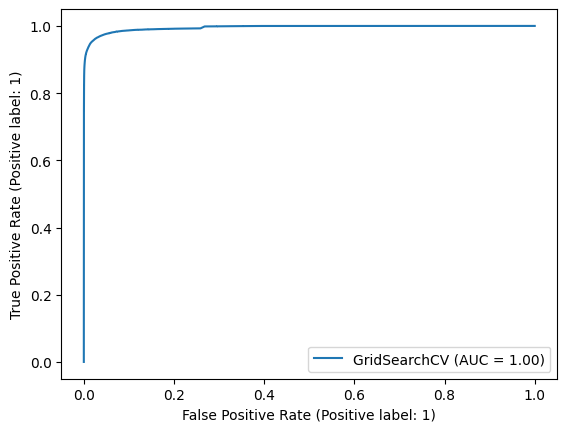

In [92]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(grid_searcher, training_set, training_targets)
plt.show()

In [12]:
test_set_dataframe = pd.read_csv("data/test_data.csv", encoding="utf8")
test_set_dataframe.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


In [16]:
number_of_authors = len(test_set_dataframe.author.unique())
predicted_test_targets = np.zeros(number_of_authors)

In [17]:
solution = pd.DataFrame({"author":test_set_dataframe.author.unique(), "gender":predicted_test_targets})
solution.head()

,author,gender
0,ejchristian86,0.0
1,ZenDragon,0.0
2,savoytruffle,0.0
3,hentercenter,0.0
4,rick-o-suave,0.0
